In [1]:
from torchvision import transforms, models
import torch.nn as nn

import torchvision.transforms as T

transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # mimic thumbnail color pop
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
]) # I'm using data augmentation to regularize the model


vision = models.resnet50(pretrained=True)
vision.fc = nn.Identity()  # remove classifier

regressor = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 1)
    
)

/users/eleves-b/2023/thomas.gastellu/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2023/thomas.gastellu/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../dataset/train_with_flashiness.csv')
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)


# Training Loop

Set training hyperparameters

In [8]:
BATCH_SIZE = 128
EPOCHS = 50
NUMBER_WORKERS = 10
PRE_FETCH = 4
FREEZE = False # if you want to freeze the vision encoder


Model and dataset setup

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class FlashinessDataset(Dataset):
    def __init__(self, df, image_dir, transform):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.image_dir}/{row['id']}.jpg").convert("RGB")
        img = self.transform(img)
        target = row["flashiness"]
        return img, torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

train_dataset = FlashinessDataset(df_train, "../dataset/train_val", transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUMBER_WORKERS, prefetch_factor=PRE_FETCH, pin_memory=True, persistent_workers=True)
val_dataset = FlashinessDataset(df_val, "../dataset/train_val", transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUMBER_WORKERS, prefetch_factor=PRE_FETCH, pin_memory=True, persistent_workers=True)

# Combine vision + regressor
class FlashinessModel(nn.Module):
    def __init__(self, vision, regressor):
        super().__init__()
        self.vision = vision
        self.regressor = regressor

    def forward(self, x):
        x = self.vision(x)
        return self.regressor(x).squeeze(1)


Actual loop

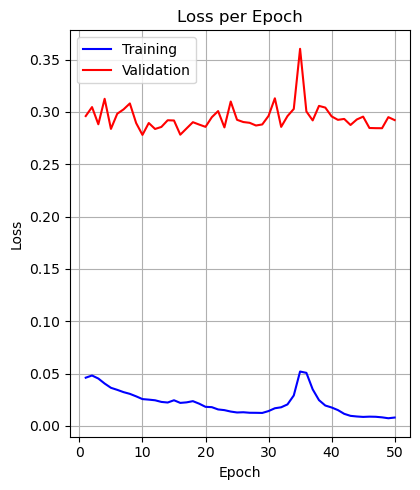

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc  # Add garbage collector

# First, clear any existing cache
torch.cuda.empty_cache()
gc.collect()

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = FlashinessModel(vision, regressor).to(device)
if FREEZE:
    for param in model.vision.parameters():
        param.requires_grad = False

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.HuberLoss(delta=1.0) # Huber loss is less sensitive to outliers than MSE


# Lists to store metrics
train_losses = []
val_losses = []
batch_losses = []

# Create a function to update the plot
def plot_losses():
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    
    # Plot batch losses
    plt.subplot(1, 2, 1)
    plt.plot(batch_losses)
    plt.title('Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot epoch losses
    plt.subplot(1, 3, 2)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training')
    plt.plot(epochs, val_losses, 'r-', label='Validation')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Training loop
epochs = EPOCHS


for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for i, (imgs, targets) in enumerate(train_loader):
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        total_train_loss += loss.item() * len(imgs)
        
        # Move tensors to CPU to free GPU memory
        imgs = imgs.cpu()
        targets = targets.cpu()
        
        # Optionally plot every N batches
        if (i + 1) % 10 == 0:  # Adjust frequency as needed
            print(f"Epoch {epoch+1}/{epochs} | Batch {i+1}/{len(train_loader)} | Loss: {batch_loss:.4f}")
            
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            
            outputs = model(imgs)
            val_loss = loss_fn(outputs, targets)
            total_val_loss += val_loss.item() * len(imgs)
            
            # Move tensors to CPU to free GPU memory
            imgs = imgs.cpu()
            targets = targets.cpu()


    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_dataset)
    avg_val_loss = total_val_loss / len(val_dataset)
    
    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Free up memory
    torch.cuda.empty_cache()
    gc.collect()
    
    plot_losses()
    
plot_losses()


# Save fine-tuned model

In [12]:
torch.save(model.vision.state_dict(), "flashiness_encoder.pth")
torch.save(model.regressor.state_dict(), "flashiness_regressor.pth")


# Test fine-tuned model

Test dataset loaded with 3097 samples


/users/eleves-b/2023/thomas.gastellu/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2023/thomas.gastellu/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 49/49 [00:04<00:00, 11.68it/s]


Test Results:
MSE: 1.1202
RMSE: 1.0584
MAE: 0.5266
R²: -0.0633


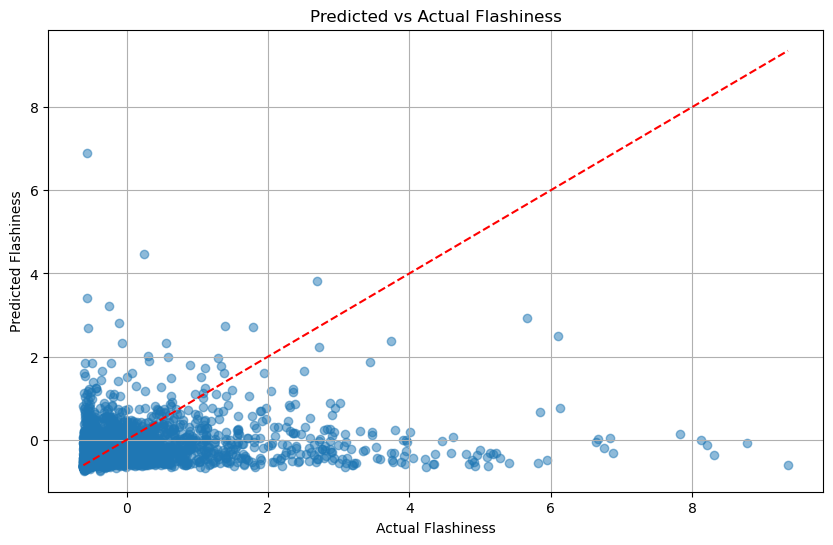

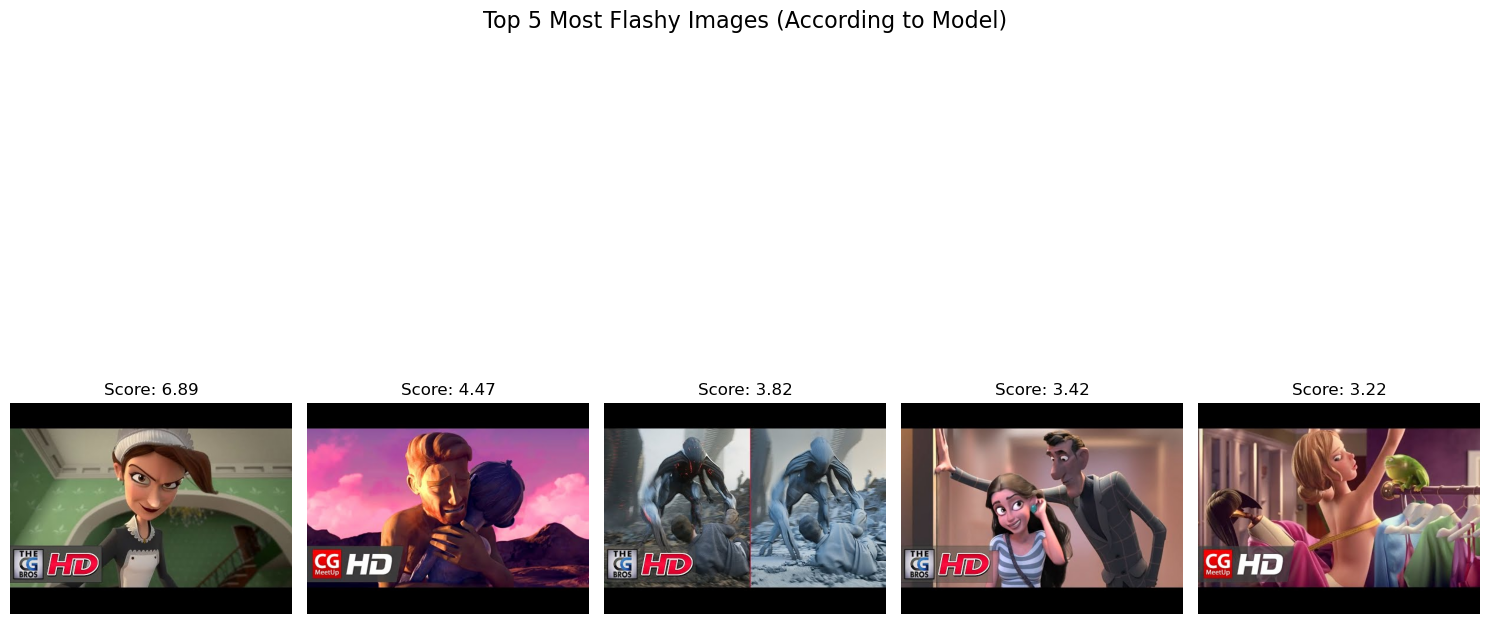

Predictions saved to flashiness_predictions.csv


In [13]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
import os
from tqdm import tqdm

# Load test data
print(f"Test dataset loaded with {len(df_val)} samples")

# Create test dataloader
test_dataset = FlashinessDataset(df_val, "../dataset/train_val", transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Recreate model architecture
vision = models.resnet50(pretrained=False)  # No need to download pretrained weights
vision.fc = nn.Identity()

regressor = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)

class FlashinessModel(nn.Module):
    def __init__(self, vision, regressor):
        super().__init__()
        self.vision = vision
        self.regressor = regressor

    def forward(self, x):
        x = self.vision(x)
        return self.regressor(x).squeeze(1)

# Load saved model weights
vision.load_state_dict(torch.load("flashiness_encoder.pth"))
regressor.load_state_dict(torch.load("flashiness_regressor.pth"))
model = FlashinessModel(vision, regressor)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation
model.eval()
predictions = []
actual = []
ids = []

with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        
        # Store predictions and ground truth
        predictions.extend(outputs.cpu().numpy().tolist())
        actual.extend(targets.numpy().tolist())
    
ids = df_val['id'].values.tolist()
# Create results dataframe
results = pd.DataFrame({
    'id': ids,
    'predicted_flashiness': predictions
})

# If we have actual flashiness values in the test set, calculate metrics
if "flashiness" in df_val.columns:
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predictions, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.xlabel('Actual Flashiness')
    plt.ylabel('Predicted Flashiness')
    plt.title('Predicted vs Actual Flashiness')
    plt.grid(True)
    plt.show()

# View the flashiest images according to the model
results_sorted = results.sort_values(by='predicted_flashiness', ascending=False)

# Display top 5 most flashy images
plt.figure(figsize=(15, 10))
plt.suptitle("Top 5 Most Flashy Images (According to Model)", fontsize=16)

for i in range(5):
    if i < len(results_sorted):
        row = results_sorted.iloc[i]
        img_path = f"../dataset/train_val/{row['id']}.jpg"
        
        if os.path.exists(img_path):
            img_path = img_path
        else:
            print(f"Image not found: {row['id']}")
            continue
            
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"Score: {row['predicted_flashiness']:.2f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Save predictions to CSV
results.to_csv("flashiness_predictions.csv", index=False)
print("Predictions saved to flashiness_predictions.csv")

compare to predictions on the test dataset

Train dataset loaded with 12385 samples


/users/eleves-b/2023/thomas.gastellu/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2023/thomas.gastellu/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Evaluating: 100%|██████████| 194/194 [00:16<00:00, 12.11it/s]

Test Results:
MSE: 0.0163
RMSE: 0.1277
MAE: 0.0839
R²: 0.9835


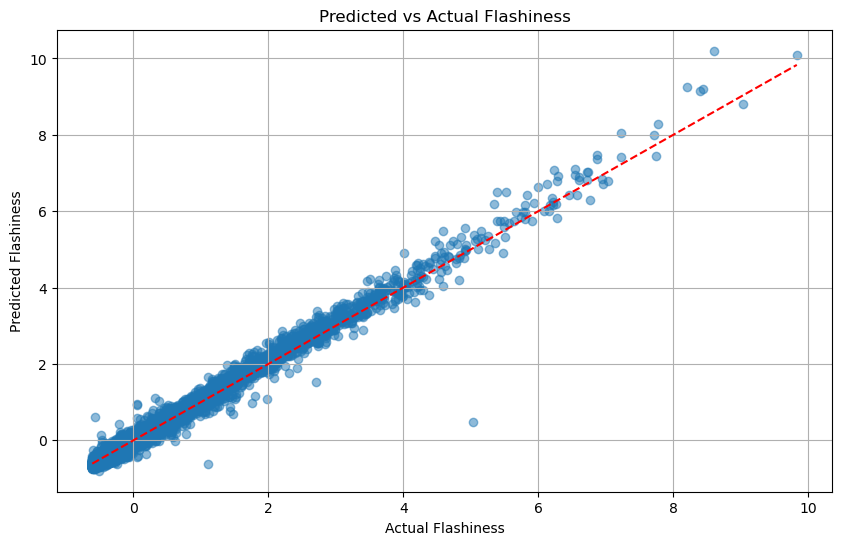

In [14]:
print(f"Train dataset loaded with {len(df_train)} samples")

# Create test dataloader
test_dataset = FlashinessDataset(df_train, "../dataset/train_val", transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Recreate model architecture
vision = models.resnet50(pretrained=False)  # No need to download pretrained weights
vision.fc = nn.Identity()

regressor = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)

class FlashinessModel(nn.Module):
    def __init__(self, vision, regressor):
        super().__init__()
        self.vision = vision
        self.regressor = regressor

    def forward(self, x):
        x = self.vision(x)
        return self.regressor(x).squeeze(1)

# Load saved model weights
vision.load_state_dict(torch.load("flashiness_encoder.pth"))
regressor.load_state_dict(torch.load("flashiness_regressor.pth"))
model = FlashinessModel(vision, regressor)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation
model.eval()
predictions = []
actual = []
ids = []

with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        
        # Store predictions and ground truth
        predictions.extend(outputs.cpu().numpy().tolist())
        actual.extend(targets.numpy().tolist())
    
ids = df_train['id'].values.tolist()
# Create results dataframe
results = pd.DataFrame({
    'id': ids,
    'predicted_flashiness': predictions
})

# If we have actual flashiness values in the test set, calculate metrics
if "flashiness" in df_train.columns:
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predictions, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.xlabel('Actual Flashiness')
    plt.ylabel('Predicted Flashiness')
    plt.title('Predicted vs Actual Flashiness')
    plt.grid(True)
    plt.show()

Okay, i'm overfitting like a madman. I think the model is learning patterns rather than flashiness cues. I will put in place data-augmentation, and look at validation loss over training. 

Okay so augmenting the epochs seems to have bettered the generalisation of the model (slightly less over-fitted)